# Activity 2: ADC, DAC and Aliasing Signals

Import the necessary libraries.

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np
import pandas as pd
import wave
import sys

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests

Modify default rc settings for MatPlotLib.

In [2]:
%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "20,5"

Function for loading audio.

In [3]:
def loadAudio(url, start, length):
    rate, data = wavfile.read(url) # Read a wavfile from filepath.
    if len(data.shape) > 1:
        data = data.sum(axis=1)
    data = (1.0 * data / abs(data).max()).astype(np.float32)
    return rate, data[rate*start+np.arange(rate*length)]

Function for adding aliasing with analysis and comparisons.

In [4]:
def presentAliasingAudio(original, rate, factor, export_filename):
    down_aliased = original[::factor] # Dumb downsampling, no anti-aliasing yet. In this case, every nth data point from the original, starting from the first value, were taken.
    b = signal.firwin(155, 1.0/factor-0.01); a=1  # Design the Anti-aliasing filter.
    lowpass = signal.lfilter(b, a, original)      # Apply the Anti-aliasing filter to the original audio.
    down_nonaliased = lowpass[::factor]           # Perform the downsampling to the anti-aliased audio.
    
    analysis_df = pd.DataFrame(columns=['Category', 'Count', 'Mean', 'Standard Deviation', 'Standard Error']) # Create a new data frame to store the analysis summary.
    EXPORTS_PATH = './exports' # Path to the exports directory.
    if not os.path.exists(EXPORTS_PATH):
        os.makedirs(EXPORTS_PATH) # Create the 'exports' directory if it does not exists.
    
    # Original
    original_mean = np.mean(original) # Calculate the mean of power for the original audio.
    original_std = np.std(original) # Calculate the standard deviation for the original audio.
    original_sem = np.std(original) / np.sqrt(np.size(original)) # Calculate the standard error for the original audio.
    original_cnt = len(original) # Number of samples for the original audio.
    
    orig_entry = {'Category':'Original', 'Count':original_cnt, 'Mean':original_mean, 'Standard Deviation':original_std, 'Standard Error':original_sem} # Create a dictionary for the entry to be added to the analysis dataframe.
    analysis_df = analysis_df.append(orig_entry, ignore_index=True) # Add the entry to the analysis dataframe.
    
    display(HTML("<h5>Original:</h5>"), Audio(data=original, rate=rate)) # HTML component to display the unaltered audio.
    plt.figure(1) # Initalize first figure.
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5)) # Initalize side-by-side figure plots for visualization of original audio.
    ax1.plot(original, color='red') # Plot the unaltered audio into a time-series plot.
    ax1.set_title("Time-series Plot for Original Signal Wave...") # Add a title for the time-series plot figure.
    ax2.hist(original, bins=500, color='red') # Plot the unaltered audio into a histogram.
    ax2.set_title("Histogram for Signal Original Wave...") # Add a title for the histogram figure.
    
    plt.show() # Display the figure for the unaltered audio.
    
    # Plot images export.
    IMG_FILENAME = '{}-original.png'.format(export_filename) # File name of the image to be exported.
    IMG_PATH = './{}/{}/images'.format(EXPORTS_PATH, export_filename) # Path to the images directory.
    if not os.path.exists(IMG_PATH):
        os.makedirs(IMG_PATH) # Create the 'images' directory if it does not exists.
    fig.savefig('{}/{}'.format(IMG_PATH, IMG_FILENAME)) # Save and export the plot to an image.
    
    print("Mean Power: {}".format(original_mean)) # Display the mean power of the unaltered audio.
    print("Standard Deviation: {}".format(original_std)) # Display the standard deviation of the unaltered audio.
    print("Standard Error: {}".format(original_sem)) # Display the standard error of the unaltered audio.
    print("Number of Samples: {}".format(original_cnt)) # Display the number of samples for the unaltered audio.
    
    
    # Downsampled
    ds_mean = np.mean(down_aliased) # Calculate the mean of power for the downsampled audio.
    ds_std = np.std(down_aliased) # Calculate the standard deviation for the downsampled audio.
    ds_sem = np.std(down_aliased) / np.sqrt(np.size(down_aliased)) # Calculate the standard error for the downsampled audio.
    ds_cnt = len(down_aliased) # Number of samples for the downsampled audio.
    
    ds_entry = {'Category':'Downsampled', 'Count':ds_cnt, 'Mean':ds_mean, 'Standard Deviation':ds_std, 'Standard Error':ds_sem} # Create a dictionary for the entry to be added to the analysis dataframe.
    analysis_df = analysis_df.append(ds_entry, ignore_index=True) # Add the entry to the analysis dataframe.
    
    display(HTML("<h5>Downsampled:</h5>"), Audio(data=down_aliased, rate=rate/factor)) # HTML component to display the downsampled audio.
    plt.figure(2) # Initalize second figure.
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5)) # Initalize side-by-side figure plots for visualization of the downsampled audio.
    ax1.plot(down_aliased, color='green') # Plot the downsampled into a time-series plot.
    ax1.set_title("Time-series Plot for Downsampled Signal Wave...") # Add a title for the time-series plot figure.
    ax2.hist(down_aliased, bins=500, color='green') # Plot the unaltered audio into a histogram.
    ax2.set_title("Histogram for Downsampled Signal Wave...") # Add a title for the histogram figure.
    
    plt.show() # Display the figure for the downsampled audio.
    
    # Plot images export.
    IMG_FILENAME = '{}-downsampled.png'.format(export_filename) # File name of the image to be exported.
    IMG_PATH = './{}/{}/images'.format(EXPORTS_PATH, export_filename) # Path to the images directory.
    if not os.path.exists(IMG_PATH):
        os.makedirs(IMG_PATH) # Create the 'images' directory if it does not exists.
    fig.savefig('{}/{}'.format(IMG_PATH, IMG_FILENAME)) # Save and export the plot to an image.
    
    print("Mean Power: {}".format(ds_mean)) # Display the mean power of the downsampled audio.
    print("Standard Deviation: {}".format(ds_std)) # Display the standard deviation of the downsampled audio.
    print("Standard Error: {}".format(ds_sem)) # Display the standard error of the downsampled audio.
    print("Number of Samples: {}".format(ds_cnt)) # Display the number of samples for the downsampled audio.
    
    
    # Anti-aliased
    aaf_mean = np.mean(down_nonaliased) # Calculate the mean of power for the audio with anti-aliasing.
    aaf_std = np.std(down_nonaliased) # Calculate the standard deviation for the audio with anti-aliasing.
    aaf_sem = np.std(down_nonaliased) / np.sqrt(np.size(down_aliased)) # Calculate the standard error for the audio with anti-aliasing.
    aaf_cnt = len(down_nonaliased) # Number of samples for the audio with anti-aliasing.
    
    aaf_entry = {'Category':'Anti-aliased', 'Count':aaf_cnt, 'Mean':aaf_mean, 'Standard Deviation':aaf_std, 'Standard Error':aaf_sem} # Create a dictionary for the entry to be added to the analysis dataframe.
    analysis_df = analysis_df.append(aaf_entry, ignore_index=True) # Add the entry to the analysis dataframe.
    
    display(HTML("<h5>With Anti-aliasing:</h5>"), Audio(data=down_nonaliased, rate=rate/factor)) # HTML component to display the audio with anti-aliasing.
    plt.figure(3) # Initalize third figure.
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5)) # Initalize side-by-side figure plots for visualization of audio with anti-aliasing.
    ax1.plot(down_nonaliased, color='blue') # Plot the unaltered audio into a time-series plot.
    ax1.set_title("Time-series Plot for Anti-aliased Signal Wave...") # Add a title for the time-series plot figure.
    ax2.hist(down_nonaliased, bins=500, color='blue') # Plot the unaltered audio into a histogram.
    ax2.set_title("Histogram for Anti-aliased Signal Wave...") # Add a title for the histogram figure.
    
    plt.show() # Display the figure for the audio with anti-aliasing.
    
    print("Mean Power: {}".format(aaf_mean)) # Display the mean power of the audio with anti-aliasing.
    print("Standard Deviation: {}".format(aaf_std)) # Display the standard deviation of the audio with anti-aliasing.
    print("Standard Error: {}".format(aaf_sem)) # Display the standard error of the audio with anti-aliasing.
    print("Number of Samples: {}".format(aaf_cnt)) # Display the number of samples for the audio with anti-aliasing.
    
    # Plot images export.
    IMG_FILENAME = '{}-antialiased.png'.format(export_filename) # File name of the image to be exported.
    IMG_PATH = './{}/{}/images'.format(EXPORTS_PATH, export_filename) # Path to the images directory.
    if not os.path.exists(IMG_PATH):
        os.makedirs(IMG_PATH) # Create the 'images' directory if it does not exists.
    fig.savefig('{}/{}'.format(IMG_PATH, IMG_FILENAME)) # Save and export the plot to an image.
    
    
    # Summary dataframe export.
    SUMMARY_PATH = './{}/{}/summary'.format(EXPORTS_PATH, export_filename) # Path to the summary directory to store csv file exports.
    if not os.path.exists(SUMMARY_PATH):
        os.makedirs(SUMMARY_PATH) # Create the 'summary' directory if it does not exists.
        
    FILE_NAME= export_filename # The filename for the .csv file.
    analysis_df.to_csv('./{}/{}.csv'.format(SUMMARY_PATH, FILE_NAME), index=False) # Exporting the file to summary directory.

Declaring the directory for datasets and loading the necessary file paths into variables.

In [5]:
DATASET_DIR = './dataset' # Dataset directory.
PATH_VOICE = "{}/obama2.wav".format(DATASET_DIR) # File path of the obama2.wav file.
PATH_MUSIC = "{}/snsd.wav".format(DATASET_DIR) # File path of the snsd.wav file.

### Voice

Load the audio and store the rate and the numpy array into variables.

In [6]:
rate_voice, data_voice = loadAudio(PATH_VOICE, 1, 10) # Load the voice file from path starting at the 1 second mark and ending at the 10 second mark.

Analysis for the `obama2.wav` voice file.

<Figure size 1440x360 with 0 Axes>

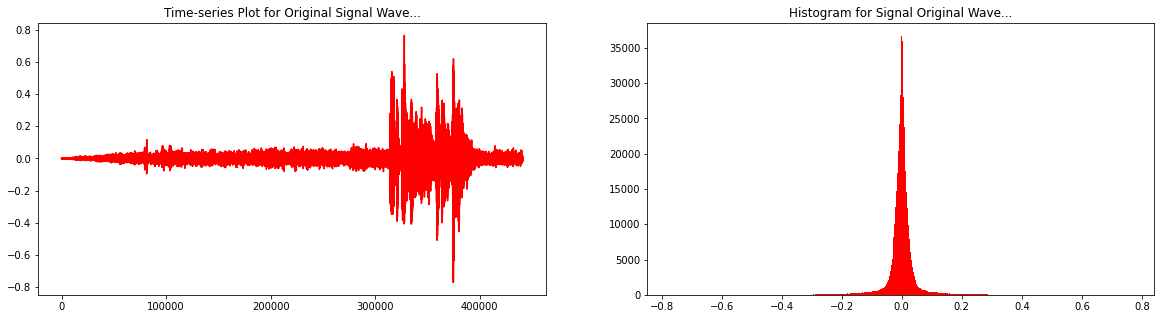

Mean Power: 1.982979301828891e-05
Standard Deviation: 0.04967868700623512
Standard Error: 7.480847719348309e-05
Number of Samples: 441000


<Figure size 1440x360 with 0 Axes>

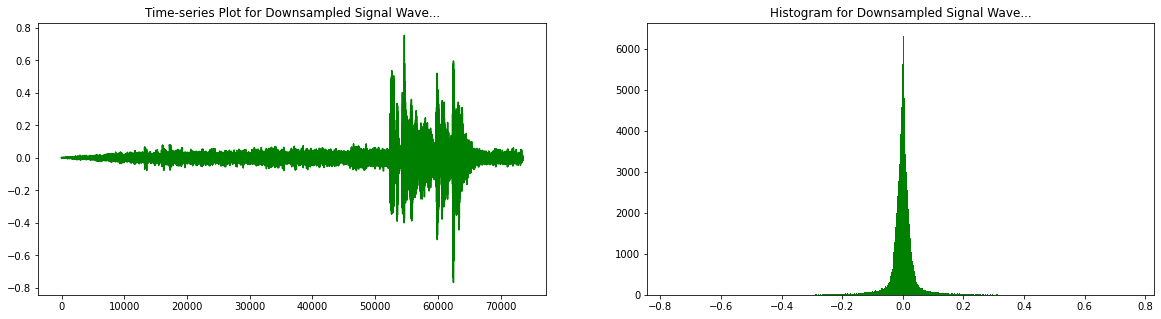

Mean Power: 3.343339994898997e-05
Standard Deviation: 0.049744054675102234
Standard Error: 0.0001834837098376211
Number of Samples: 73500


<Figure size 1440x360 with 0 Axes>

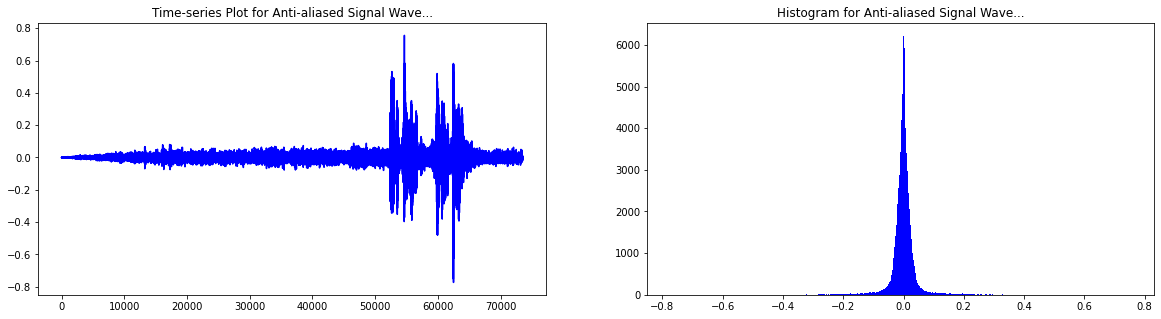

Mean Power: 2.0399506216764435e-05
Standard Deviation: 0.04762228005036683
Standard Error: 0.00017565742623190138
Number of Samples: 73500


In [7]:
presentAliasingAudio(data_voice, rate_voice, 6, 'voice_obama2_summary') # Execute analysis for the voice file.

Show the dataframe of the generated csv file containing the summary of analysis.

In [8]:
VOICE_OBAMA_SUMMARY_PATH = './exports/voice_obama2_summary/summary/voice_obama2_summary.csv' # Declare the path of the .csv file.
voice_obama_summary_df = pd.read_csv(VOICE_OBAMA_SUMMARY_PATH) # Load the .csv file.
voice_obama_summary_df # Preview the entries for the dataframe.

,Category,Count,Mean,Standard Deviation,Standard Error
0,Original,441000,0.000020,0.049679,0.000075
1,Downsampled,73500,0.000033,0.049744,0.000183
2,Anti-aliased,73500,0.000020,0.047622,0.000176


### Music
Analysis for the `snsd.wav` music file.

Load the audio and store the rate and the numpy array into variables.

In [9]:
rate_music, data_music = loadAudio(PATH_MUSIC, 1, 10) # Load the music file from path starting at 1 second mark and ending at 10 second mark.

Analysis for the `obama2.wav` voice file.

<Figure size 1440x360 with 0 Axes>

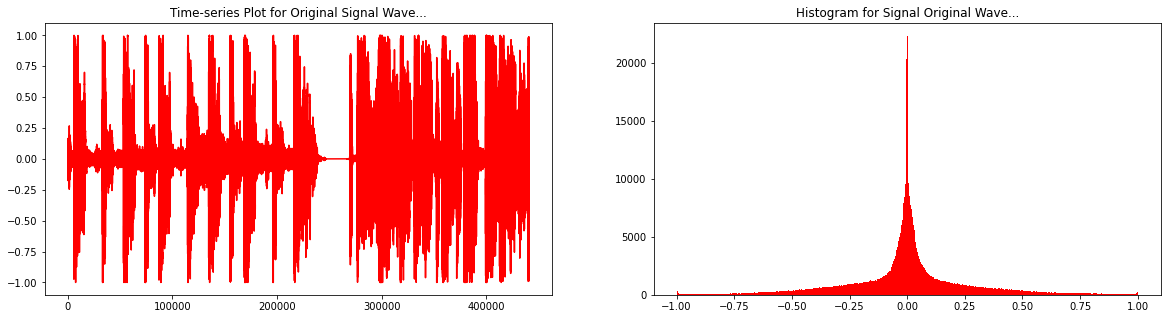

Mean Power: -0.00032216476392932236
Standard Deviation: 0.26798689365386963
Standard Error: 0.0004035471271521672
Number of Samples: 441000


<Figure size 1440x360 with 0 Axes>

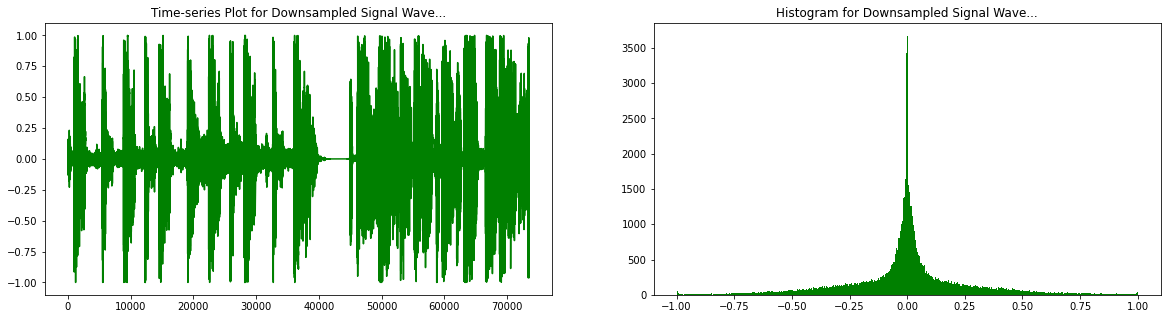

Mean Power: -0.0001911249419208616
Standard Deviation: 0.2683092951774597
Standard Error: 0.0009896737446237634
Number of Samples: 73500


<Figure size 1440x360 with 0 Axes>

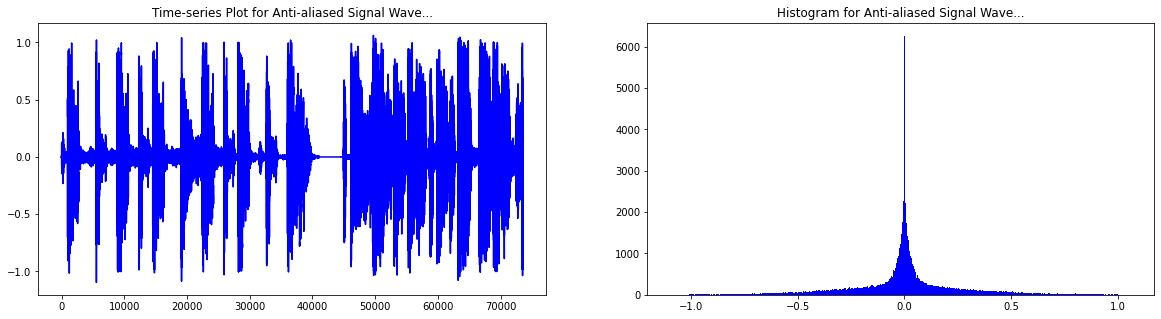

Mean Power: -0.0002444746520186979
Standard Deviation: 0.26158118003340464
Standard Error: 0.0009648567180482479
Number of Samples: 73500


In [10]:
presentAliasingAudio(data_music, rate_music, 6, 'music_snsd_summary') # Execute analysis for the music file.

In [11]:
MUSIC_SNSD_SUMMARY_PATH = './exports/music_snsd_summary/summary/music_snsd_summary.csv' # Declare the path of the .csv file.
music_snsd_summary_df = pd.read_csv(MUSIC_SNSD_SUMMARY_PATH) # Load the .csv file.
music_snsd_summary_df # Preview the entries for the dataframe.

,Category,Count,Mean,Standard Deviation,Standard Error
0,Original,441000,-0.000322,0.267987,0.000404
1,Downsampled,73500,-0.000191,0.268309,0.000990
2,Anti-aliased,73500,-0.000244,0.261581,0.000965
